In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras 
from keras.utils import plot_model 
import tensorflow as tf 

img_width = 180 
img_height = 180
layer_names = ['conv2_block1_1_conv', 'conv5_block3_3_conv']


#### importiazione modello preaddestrato ResNet50V2

In [2]:
resnet_model = keras.applications.ResNet50V2(weights = 'imagenet', include_top = False)

resnet_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, None, None, 64)       0         ['conv1_conv[0][0]']          
                                                                                         

#### Configurare un modello che restituisca i valori di attivazione per il nostro layer di destinazione

In [3]:
layers = [ resnet_model.get_layer(name=layer_name) for layer_name in layer_names]
feature_extractor = keras.Model(
    inputs=resnet_model.inputs, 
    outputs=[ layer.output for layer in layers ]
)

#### Questa funzione, chiamata compute_loss, viene utilizzata per calcolare la perdita (loss) associata all'attivazione di un filtro specifico in un determinato layer del modello 

In [4]:
def compute_loss(input_image, level_index, filter_index):
    activation = feature_extractor(input_image)
    print(activation)
    filter_activation = activation[level_index][:,:,:, filter_index]
    return tf.reduce_mean(filter_activation)

#### Implemento ascensione del gradiente per ottimizzare l'immagine di input al fine di massimizzare l'attivazione di un filtro specifico in un determinato layer

In [5]:
@tf.function
def gradient_ascent_step(img, level_index, learning_rate, filter_index):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, level_index, filter_index)
    grads = tape.gradient(loss, img)
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

* Creazione di un rumore uniforme di input
* Visualizzazione di 30 filtri con ascesa del gradiente
* Normalizzazione delle immagini in array
* Conversione in array RGB

In [6]:
def initialize_image():
    img = tf.random.uniform((1, img_width, img_height, 3))
    return (img - 0.5) * .25

def visualize_filter(level_index, filter_index):
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, level_index, learning_rate, filter_index)
    img = deprocess_image(img[0].numpy())
    return loss, img

def deprocess_image(img):
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15
    img = img[25:-25, 25:-25, :]
    img += 0.5
    img = np.clip(img, 0, 1)
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

#### Visualizzazione filtro n. 0 al livello convolutivo di uscita conv3_block4

[<tf.Tensor 'model/conv2_block1_1_conv/Conv2D:0' shape=(1, 45, 45, 64) dtype=float32>, <tf.Tensor 'model/conv5_block3_3_conv/BiasAdd:0' shape=(1, 6, 6, 2048) dtype=float32>]


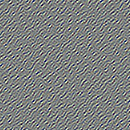

In [7]:
from IPython.display import Image, display

loss, img = visualize_filter(0, 0)
keras.preprocessing.image.save_img("level_start_gray.png", img)
display(Image("level_start_gray.png"))

#### Visualizzazione filtro n. 1 al livello convolutivo di uscita conv3_block4

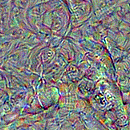

In [10]:
loss, img = visualize_filter(1, 0)
tf.keras.preprocessing.image.save_img("level_end_gray.png", img)
display(Image("level_end_gray.png"))

* Calcolo le immagini che massimizzano l'attivazione dei primi 64 filtri del layer scelto
* Costruisco un immagine 8X8 filtri di dim. 128X128 con margine di 5 PXL
* Riempio img con i filtri salvati

Processing filter 0
Processing filter 1
[<tf.Tensor 'model/conv2_block1_1_conv/Conv2D:0' shape=(1, 45, 45, 64) dtype=float32>, <tf.Tensor 'model/conv5_block3_3_conv/BiasAdd:0' shape=(1, 6, 6, 2048) dtype=float32>]
Processing filter 2
[<tf.Tensor 'model/conv2_block1_1_conv/Conv2D:0' shape=(1, 45, 45, 64) dtype=float32>, <tf.Tensor 'model/conv5_block3_3_conv/BiasAdd:0' shape=(1, 6, 6, 2048) dtype=float32>]
Processing filter 3
[<tf.Tensor 'model/conv2_block1_1_conv/Conv2D:0' shape=(1, 45, 45, 64) dtype=float32>, <tf.Tensor 'model/conv5_block3_3_conv/BiasAdd:0' shape=(1, 6, 6, 2048) dtype=float32>]
Processing filter 4
[<tf.Tensor 'model/conv2_block1_1_conv/Conv2D:0' shape=(1, 45, 45, 64) dtype=float32>, <tf.Tensor 'model/conv5_block3_3_conv/BiasAdd:0' shape=(1, 6, 6, 2048) dtype=float32>]
Processing filter 5
[<tf.Tensor 'model/conv2_block1_1_conv/Conv2D:0' shape=(1, 45, 45, 64) dtype=float32>, <tf.Tensor 'model/conv5_block3_3_conv/BiasAdd:0' shape=(1, 6, 6, 2048) dtype=float32>]
Processing

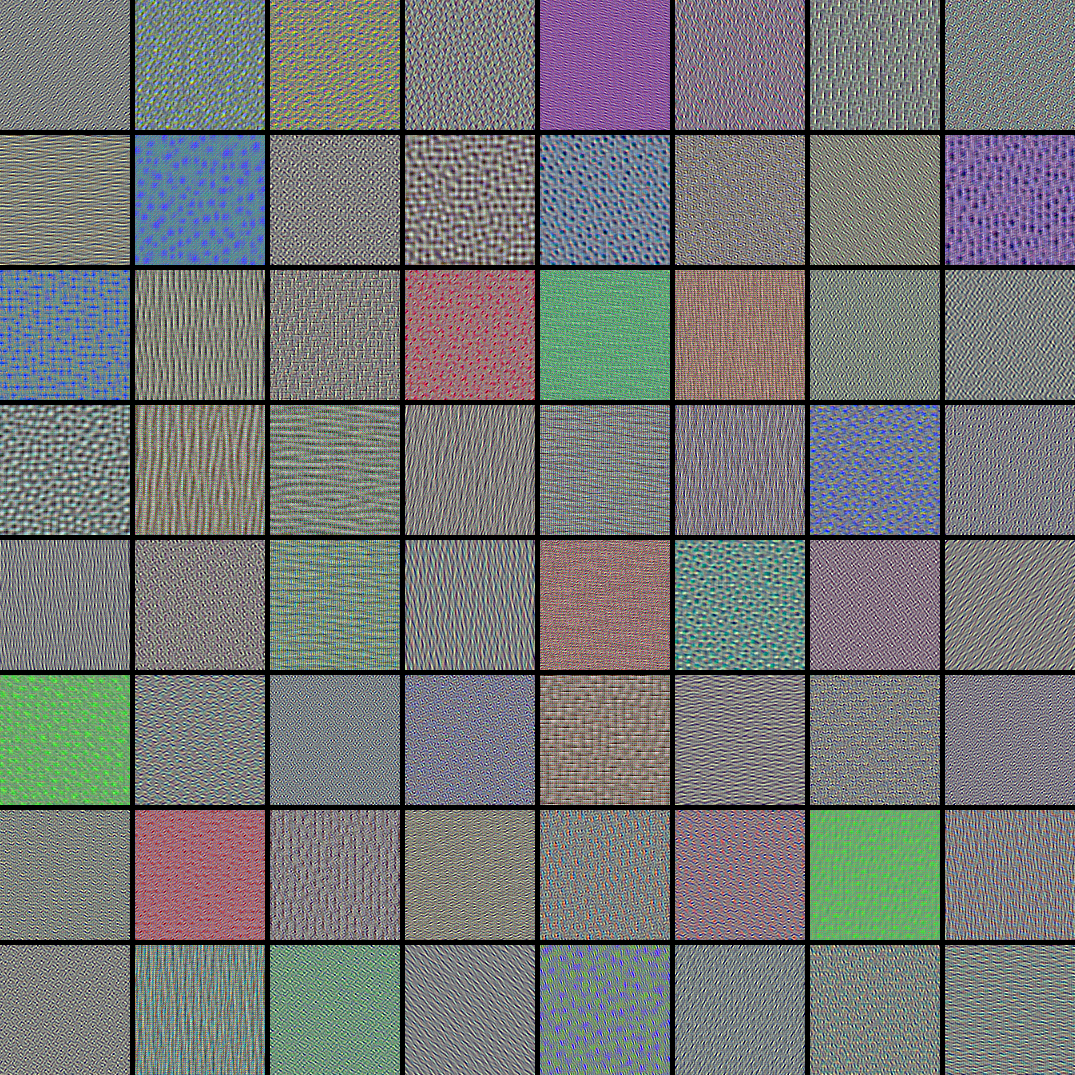

In [11]:
all_imgs = []
for filter_index in range(64):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(0, filter_index)
    all_imgs.append(img)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("stiched_filters_uniform_start.png", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters_uniform_start.png"))

#### Faccio  la stessa operazione effettuata prima ma su un layer piu deep e possiamo notare come in alto livello vengono estratte features piu elementari e mano mano che si scende troviamo features sempre piu complesse 
* Utilizzando l'ascesa del gradiente facciamo si che si accendano i filtri inutilizzati 
essendo la nostra solo un immagine di disturbo possiamo vedere come il modello cerca di trovare immagini all'interno quando il nostro input e solo disturbo e questo 
fenomeno e anche comunemente chiamato ' i sogni delle IA' o 'Deep Dream'

Processing filter 0
Processing filter 1
[<tf.Tensor 'model/conv2_block1_1_conv/Conv2D:0' shape=(1, 45, 45, 64) dtype=float32>, <tf.Tensor 'model/conv5_block3_3_conv/BiasAdd:0' shape=(1, 6, 6, 2048) dtype=float32>]
Processing filter 2
[<tf.Tensor 'model/conv2_block1_1_conv/Conv2D:0' shape=(1, 45, 45, 64) dtype=float32>, <tf.Tensor 'model/conv5_block3_3_conv/BiasAdd:0' shape=(1, 6, 6, 2048) dtype=float32>]
Processing filter 3
[<tf.Tensor 'model/conv2_block1_1_conv/Conv2D:0' shape=(1, 45, 45, 64) dtype=float32>, <tf.Tensor 'model/conv5_block3_3_conv/BiasAdd:0' shape=(1, 6, 6, 2048) dtype=float32>]
Processing filter 4
[<tf.Tensor 'model/conv2_block1_1_conv/Conv2D:0' shape=(1, 45, 45, 64) dtype=float32>, <tf.Tensor 'model/conv5_block3_3_conv/BiasAdd:0' shape=(1, 6, 6, 2048) dtype=float32>]
Processing filter 5
[<tf.Tensor 'model/conv2_block1_1_conv/Conv2D:0' shape=(1, 45, 45, 64) dtype=float32>, <tf.Tensor 'model/conv5_block3_3_conv/BiasAdd:0' shape=(1, 6, 6, 2048) dtype=float32>]
Processing

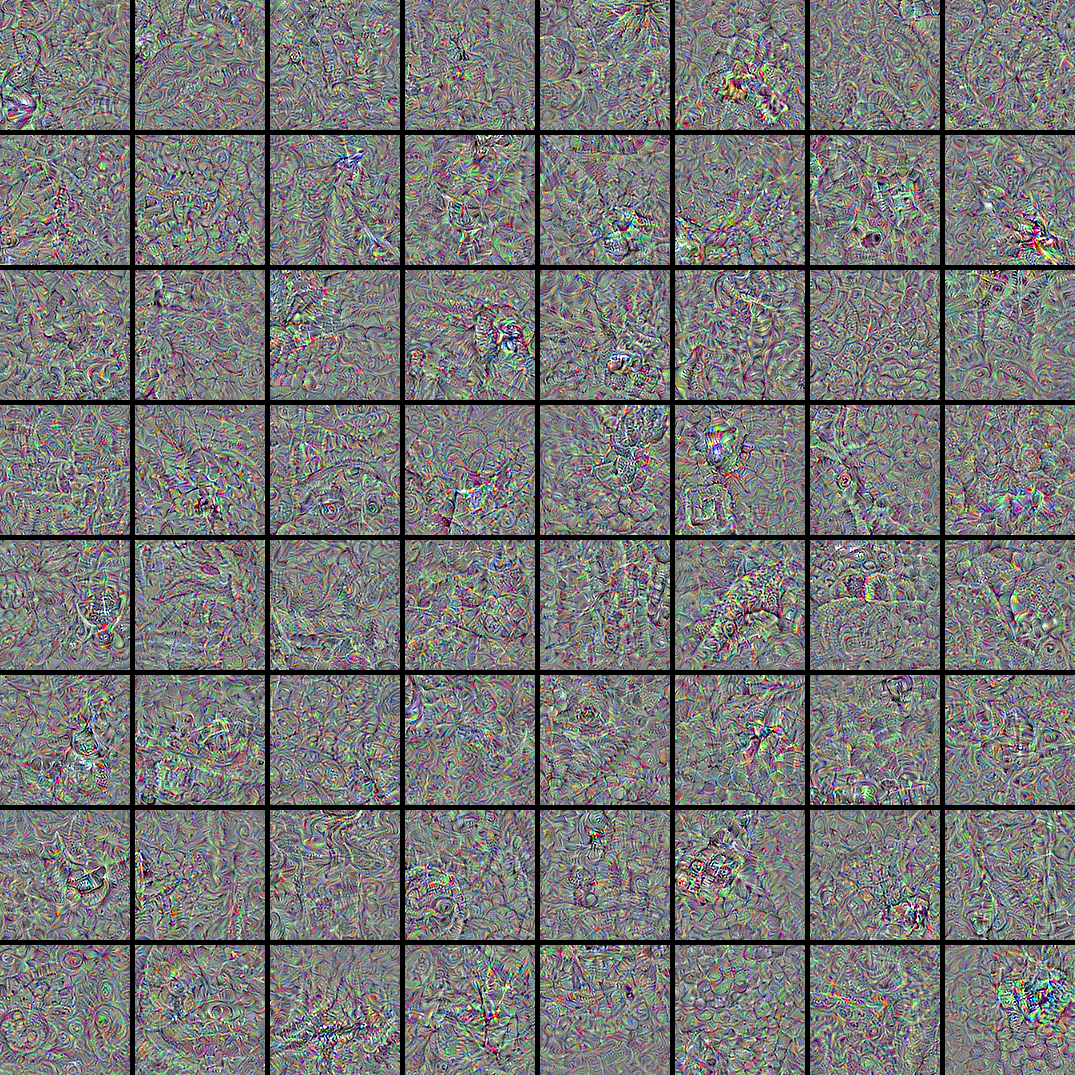

In [12]:
all_imgs = []
for filter_index in range(64):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(1, filter_index)
    all_imgs.append(img)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("stiched_filters_uniform_end.png", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters_uniform_end.png"))